In [3]:
import cylinterp
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
plt.style.use('default')

# Geometry class

The geometry class is useful for building a cylindrical grid and exporting it to COMSOL

In [4]:
ra, rc = 5e-4, 4 #Inner and outer radius in cm
#Set the min z, max z, number of radii, number of z, number in the first ring
z0, z1, nr, nz, n_first_ring = -1, 11, 60, 100, 8

geometry = cylinterp.Geometry.UniformCylindricalGrid(ra, rc, z0, z1, nr, nz, n_first_ring)

Text(0, 0.5, 'y [cm]')

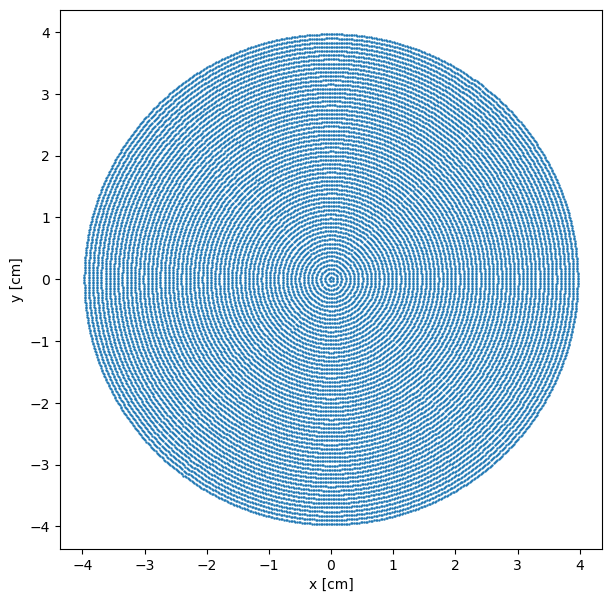

In [5]:
plt.figure(figsize = (7,7))
plt.scatter(geometry.r_coords*np.cos(geometry.theta_coords),
            geometry.r_coords*np.sin(geometry.theta_coords),
            s = 0.5)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

We can also export this grid to a csv file that can be fed into COMSOL

In [6]:
geometry.ComsolGrid()

,x,y,z
0,3.439407e-02,0.000000e+00,-1.0
1,2.432028e-02,2.432028e-02,-1.0
2,2.106029e-18,3.439407e-02,-1.0
3,-2.432028e-02,2.432028e-02,-1.0
4,-3.439407e-02,4.212059e-18,-1.0
...,...,...,...
2745095,3.963809e+00,-1.349673e-01,11.0
2745096,3.964636e+00,-1.079814e-01,11.0
2745097,3.965279e+00,-8.099040e-02,11.0
2745098,3.965738e+00,-5.399569e-02,11.0


In [7]:
# geometry.ExportGrid('test_data/ExampleComsolGrid.csv')

# Physics Module

The Physics module has two classes: Physics and RTPC (though you can add more)

## The Field Class

The Field class loads in the field using the coordinates generated by the UniformCylindricalGrid class. This class MUST have a consistent coordinate system with the corresponding UniformCylindricalGrid class. This puts the field map in a dataframe with all 3 components. This also provides an interpolation function for the field.

In [ ]:
sag = 1
field = cylinterp.Physics.Field(ra, rc, z0, z1, nr, nz, n_first_ring, f'test_data/4500V_1mmSag_Run29.txt')

In [6]:
n_pts = 10000
th0 = np.pi/4
r_edge = 2.5
r_values = np.linspace(geometry.unique_r_coords[0], r_edge, n_pts) #cm
theta_values = np.repeat(th0, n_pts) #radians
z_values = np.repeat(5., n_pts) #cm

pts = np.array([z_values, r_values, theta_values]).T

Text(0, 0.5, 'E [V/cm]')

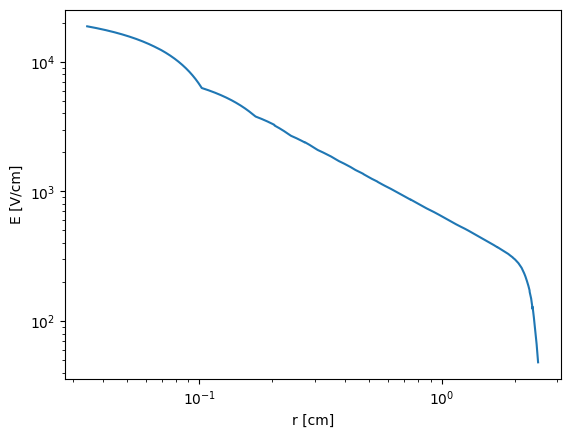

In [7]:
plt.plot(r_values, np.linalg.norm(field.Interpolate(pts), axis = 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [cm]')
plt.ylabel('E [V/cm]')

#The bumps are an artifact of using a linear interpolation

## The RTPC Class
This sets up the drift which allows us to compute drift tiems

In [8]:
n_cathode_wires = 20
rtpc = cylinterp.Physics.RTPC(ra, rc, z0, z1, nr, nz, n_first_ring,
                              f'test_data/4500V_1mmSag_Run29.txt',
                              n_cathode_wires, r_edge,
                              sag/10)

### Plotting

In [104]:
import cProfile

profiler = cProfile.Profile()
profiler.enable()
dt, status, ztracks, rtracks, thtracks, init_points, end_points = rtpc.Drift(n_pts = 100,
                                                                             r = fixed_rand_coords,
                                                                     # sampleregion = {'zmin': 3,
                                                                     #                 'zmax': 3.5,
                                                                     #                 'rmin': rtpc.unique_r_coords[0],
                                                                     #                 'rmax': 2.5},
                                                                cath_thresh=300e-4)
profiler.disable()

In [9]:
geometry.unique_r_coords[0]

0.03439406779661017

In [1]:
# profiler.print_stats(sort = 'tottime')

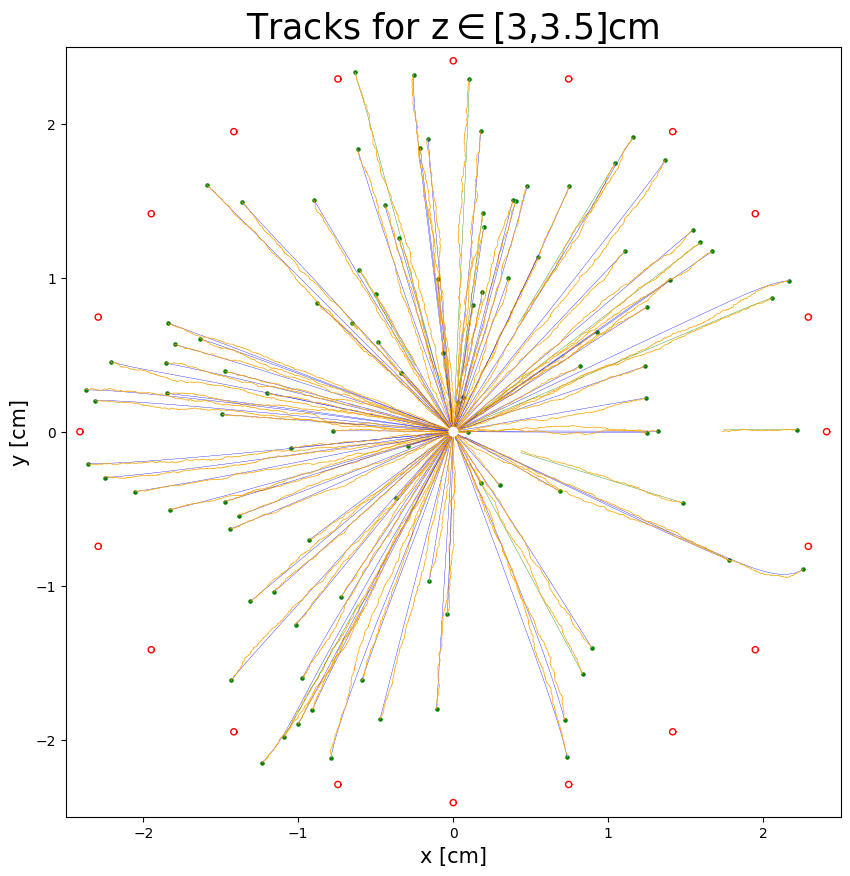

In [117]:
radius_of_trouble = 200e-4
pangle = np.linspace(0,2*np.pi, 100)
cart_points = cylinterp.Tools.to_cartesian(init_points)

plt.figure(figsize = (10,10))
cath_pos = rtpc.cathode_position(3.25)[0]

for i in range(100):
    if status[i]==0:
        c = 'blue'
    elif status[i]==1:
        c = 'red'
    elif status[i]==2:
        c = 'black'
    else:
        c = 'green'
    buffer_cut = rtracks[i]!=0
    buffer_cut_cpp = cpp_r_tracks[i]!=0
    plt.plot(rtracks[i][buffer_cut]*np.cos(thtracks[i][buffer_cut]),
             rtracks[i][buffer_cut]*np.sin(thtracks[i][buffer_cut]), color = c, linewidth = 0.25)
    plt.scatter(cart_points[i][0], cart_points[i][1], s = 5, color = 'g')

for p in cath_pos:
    # plt.scatter(p[0], p[1], color = 'r')
    plt.plot(radius_of_trouble*np.cos(pangle)+p[0],
             radius_of_trouble*np.sin(pangle)+p[1], color = 'r', linewidth = 1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x [cm]', fontsize = 15)
plt.ylabel('y [cm]', fontsize = 15)
plt.title(r'Tracks for z$\in$[3,3.5]cm', fontsize = 25)
plt.show()

In [118]:
dt, status, ztracks, rtracks, thtracks, init_points, end_points = rtpc.Drift(n_pts = 10000)

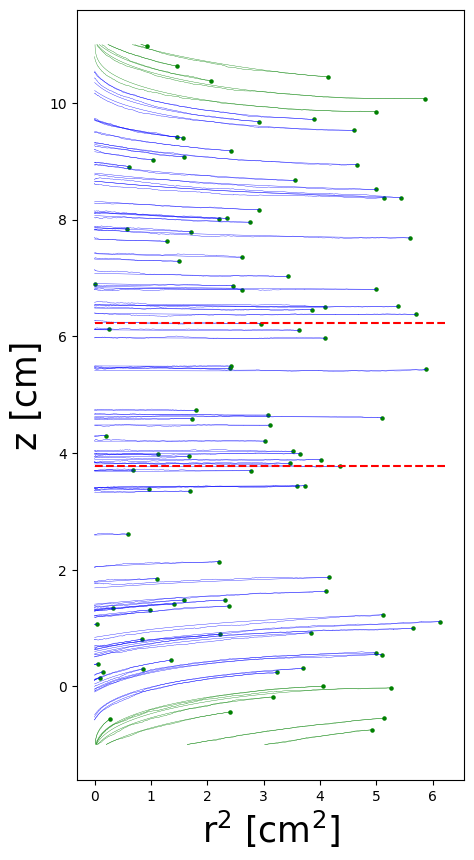

In [119]:
radius_of_trouble = 200e-4
pangle = np.linspace(0,2*np.pi, 100)
cart_points = cylinterp.Tools.to_cartesian(init_points)

plt.figure(figsize = (5,10))
cath_pos = rtpc.cathode_position(3.25)[0]

for i in range(100):
    if status[i]==0:
        c = 'blue'
    elif status[i]==1:
        c = 'red'
    elif status[i]==2:
        c = 'black'
    else:
        c = 'green'
    buffer_cut = rtracks[i]!=0
    buffer_cut_cpp = cpp_r_tracks[i]!=0
    
    plt.plot(rtracks[i][buffer_cut]**2,
             ztracks[i][buffer_cut], color = c, linewidth = 0.25)
    plt.plot(cpp_r_tracks[i][buffer_cut_cpp]**2,
             cpp_z_tracks[i][buffer_cut_cpp], color = c, linewidth = 0.25)
    plt.scatter((cart_points[i][0]**2+cart_points[i][1]**2),
                cart_points[i][2], s = 5, color = 'g')
    

central_z = 2.465952715464704
plt.hlines([5+central_z/2, 5-central_z/2], 0,2.5**2, linestyle = 'dashed', color = 'r')
plt.xlabel(r'r$^2$ [cm$^2$]', fontsize = 25)
plt.ylabel('z [cm]', fontsize = 25)
plt.show()

### Diffusion

In [15]:
dt, status, ztracks, rtracks, thtracks, init_points, end_points = rtpc.Drift(n_pts = 10,
                                                                             r=np.tile([5,2,0.5],(10,1)),
                                                                             cath_thresh=300e-4, diffusion=True)

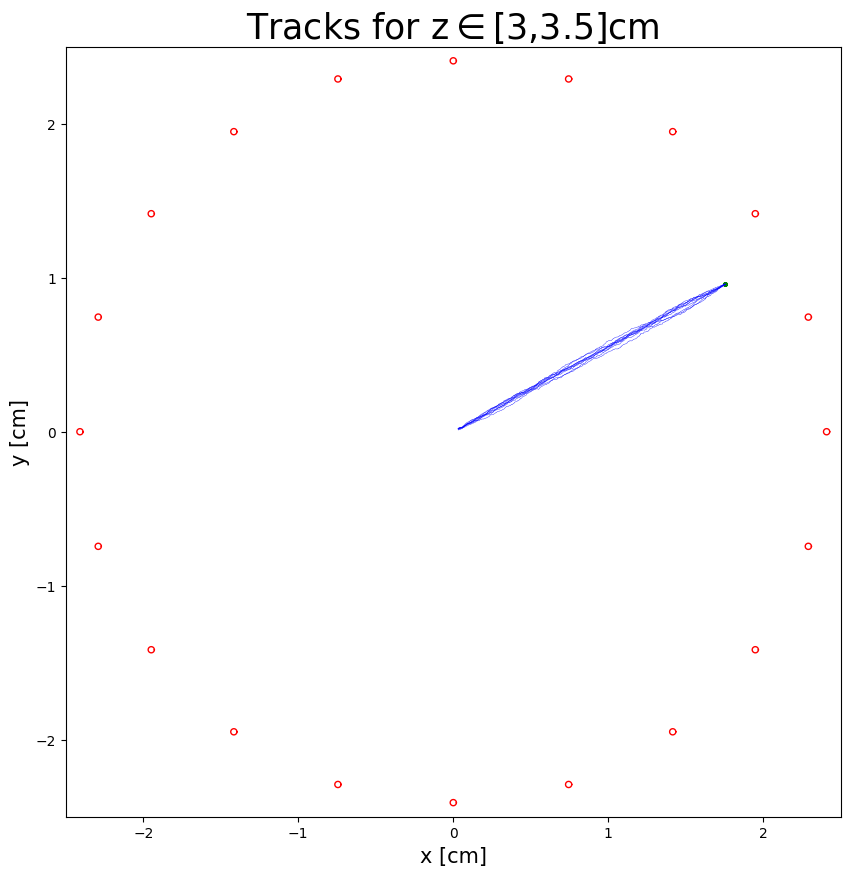

In [8]:
radius_of_trouble = 200e-4
pangle = np.linspace(0,2*np.pi, 100)
cart_points = cylinterp.Tools.to_cartesian(init_points)

plt.figure(figsize = (10,10))
cath_pos = rtpc.cathode_position(3.25)[0]

for i in range(10):
    if status[i]==0:
        c = 'blue'
    elif status[i]==1:
        c = 'red'
    elif status[i]==2:
        c = 'black'
    else:
        c = 'green'
    buffer_cut = rtracks[i]!=0
    plt.plot(rtracks[i][buffer_cut]*np.cos(thtracks[i][buffer_cut]),
             rtracks[i][buffer_cut]*np.sin(thtracks[i][buffer_cut]), color = c, linewidth = 0.25)
    plt.scatter(cart_points[i][0], cart_points[i][1], s = 5, color = 'g')

for p in cath_pos:
    # plt.scatter(p[0], p[1], color = 'r')
    plt.plot(radius_of_trouble*np.cos(pangle)+p[0],
             radius_of_trouble*np.sin(pangle)+p[1], color = 'r', linewidth = 1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x [cm]', fontsize = 15)
plt.ylabel('y [cm]', fontsize = 15)
plt.title(r'Tracks for z$\in$[3,3.5]cm', fontsize = 25)
plt.show()

In [36]:
dt, status, ztracks, rtracks, thtracks, init_points, end_points = rtpc.Drift(n_pts = 10,
                                                                            r = np.tile([6,2.2,0.5], (10,1)),
                                                                            diffusion=True)

In [17]:
import time
t0 = time.time()
dt, status, init_points, end_points = rtpc.Drift(n_pts = 10,
                                                r = np.tile([9.8,2.2,0.5], (10,1)),
                                                diffusion=True,
                                                tracking=False)
print(time.time()-t0)

0.6497657299041748


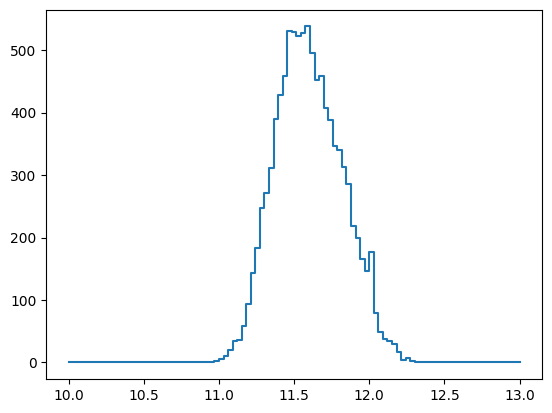

In [19]:
from multihist import Hist1d
Hist1d(dt, bins = np.linspace(10,13,100)).plot()

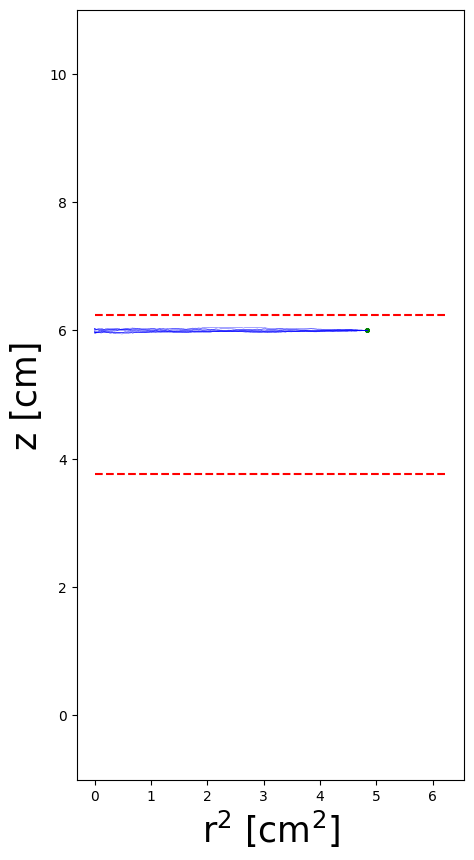

In [37]:
radius_of_trouble = 200e-4
pangle = np.linspace(0,2*np.pi, 100)
cart_points = cylinterp.Tools.to_cartesian(init_points)

plt.figure(figsize = (5,10))
cath_pos = rtpc.cathode_position(3.25)[0]

for i in range(10):
    if status[i]==0:
        c = 'blue'
    elif status[i]==1:
        c = 'red'
    elif status[i]==2:
        c = 'black'
    else:
        c = 'red'
    buffer_cut = rtracks[i]!=0
    
    plt.plot(rtracks[i][buffer_cut]**2,
             ztracks[i][buffer_cut], color = c, linewidth = 0.25)
    plt.scatter((cart_points[i][0]**2+cart_points[i][1]**2),
                cart_points[i][2], s = 5, color = 'g')
    

central_z = 2.465952715464704
plt.hlines([5+central_z/2, 5-central_z/2], 0,2.5**2, linestyle = 'dashed', color = 'r')
plt.xlabel(r'r$^2$ [cm$^2$]', fontsize = 25)
plt.ylabel('z [cm]', fontsize = 25)
plt.ylim(-1,11)
plt.show()